# Определение стоимости недвижимости в Мск

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    mean_squared_log_error

from catboost import CatBoostRegressor
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

RAND = 10
TEST_SIZE = 0.25
N_THREADS = 4
N_FOLDS = 3
TIMEOUT = 300

In [3]:
df = pd.read_csv('../data/moscow.csv')

In [4]:
df

price        date      time    geo_lat    geo_lon  region  \
0        4704280  2018-03-04  12:35:25  55.621097  37.431002       3   
1        8000000  2018-03-17  06:46:32  55.738876  37.825370       3   
2       11500000  2018-04-03  17:40:53  55.798921  37.738090       3   
3       10200000  2018-04-07  15:23:20  55.655307  37.614605       3   
4       11500000  2018-04-18  21:52:41  55.701330  37.507412       3   
...          ...         ...       ...        ...        ...     ...   
439506  12850000  2021-05-01  20:13:47  55.701280  37.642654       3   
439507  19739760  2021-05-01  20:13:58  55.804736  37.750898       3   
439508  12503160  2021-05-01  20:14:01  55.841415  37.489624       3   
439509  11831910  2021-05-01  20:14:12  55.804736  37.750898       3   
439510  13316200  2021-05-01  20:14:15  55.860240  37.540356       3   

        building_type  level  levels  rooms  area  kitchen_area  object_type  
0                   2      1      25      1  31.7           6.0           11  
1                   1      5       9      2  45.0           6.0            1  
2                   1     14      16      3  64.9           8.0            1  
3                   2      7      14      2  52.8          10.0            1  
4                   1     14      17      1  42.0          12.0            1  
...               ...    ...     ...    ...   ...           ...          ...  
439506              2     12      24      1  41.0           9.0            1  
439507              1      8      17      4  93.2          13.8           11  
439508              2     17      32      2  45.9           6.6           11  
439509              1      8      33      2  52.1          18.9           11  
439510              2     10      23      2  55.6          20.8           11  

[439511 rows x 13 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439511 entries, 0 to 439510
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          439511 non-null  int64  
 1   date           439511 non-null  object 
 2   time           439511 non-null  object 
 3   geo_lat        439511 non-null  float64
 4   geo_lon        439511 non-null  float64
 5   region         439511 non-null  int64  
 6   building_type  439511 non-null  int64  
 7   level          439511 non-null  int64  
 8   levels         439511 non-null  int64  
 9   rooms          439511 non-null  int64  
 10  area           439511 non-null  float64
 11  kitchen_area   439511 non-null  float64
 12  object_type    439511 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 43.6+ MB


In [6]:
df.describe()

price        geo_lat        geo_lon    region  building_type  \
count  4.395110e+05  439511.000000  439511.000000  439511.0  439511.000000   
mean   1.313957e+07      55.721659      37.577732       3.0       1.846659   
std    1.945564e+07       0.107314       0.146706       0.0       0.792431   
min   -2.089967e+09      55.179939      36.836900       3.0       0.000000   
25%    6.962944e+06      55.642083      37.479919       3.0       1.000000   
50%    9.350000e+06      55.725486      37.575703       3.0       2.000000   
75%    1.350000e+07      55.803803      37.682966       3.0       2.000000   
max    1.096745e+09      56.655467      38.059246       3.0       5.000000   

               level         levels          rooms           area  \
count  439511.000000  439511.000000  439511.000000  439511.000000   
mean        8.510465      16.305155       1.820940      58.111338   
std         6.464976       7.535946       1.160408      36.085213   
min         1.000000       1.000000      -2.000000       1.400000   
25%         3.000000      10.000000       1.000000      38.900000   
50%         7.000000      16.000000       2.000000      53.000000   
75%        12.000000      22.000000       3.000000      70.000000   
max        39.000000      39.000000      10.000000    5200.000000   

        kitchen_area    object_type  
count  439511.000000  439511.000000  
mean       11.983181       5.292771  
std         6.651784       4.949736  
min         0.100000       1.000000  
25%         8.000000       1.000000  
50%        10.500000       1.000000  
75%        15.000000      11.000000  
max      1200.000000      11.000000

In [7]:
df.isna().sum()

price            0
date             0
time             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

In [8]:
DROP_COLS = ["date", "time", "geo_lat", "geo_lon", "region"]
CATEGORICAL_FEATURES = ["building_type", "object_type"]
NUMERIC_FEATURES = ["level", "levels", "rooms", "area", "kitchen_area"]

In [9]:
df = df.drop(columns=DROP_COLS)

In [10]:
# Remove outliers
df = df[df.price.between(df.price.quantile(0.05), df.price.quantile(0.95))]
df = df[df.area.between(df.area.quantile(0.01), df.area.quantile(0.99))]
df = df[df.rooms > -2]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387929 entries, 0 to 439510
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          387929 non-null  int64  
 1   building_type  387929 non-null  int64  
 2   level          387929 non-null  int64  
 3   levels         387929 non-null  int64  
 4   rooms          387929 non-null  int64  
 5   area           387929 non-null  float64
 6   kitchen_area   387929 non-null  float64
 7   object_type    387929 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 26.6 MB


## Метрики

In [12]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics['RMSLE'] = rmsle(y_test, y_pred)
    df_metrics['R2 adjusted'] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics['MPE_%'] = mpe(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)

    return df_metrics


def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train)
    mae_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test)/mae_train*100):.1f} %')

## Обучение моделей

In [13]:
X = df.drop(['price'], axis=1)
y = df['price']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=TEST_SIZE,
                                                    random_state=RAND)

eval_set = [(X_val, y_val)]

### Baseline

In [15]:
# from sklearn.compose import ColumnTransformer
# transformers_list = [
#     ('encode', OneHotEncoder(dtype='int', drop='first'), CATEGORICAL_FEATURES),
#     ('scale', StandardScaler(), NUMERIC_FEATURES)
# ]

# column_transformer = ColumnTransformer(transformers_list)

In [16]:
# X_train_transformed = pd.DataFrame.sparse.from_spmatrix(column_transformer.fit_transform(X_train))
# X_test_transformed = pd.DataFrame.sparse.from_spmatrix(column_transformer.transform(X_test))
# X_val_transformed = pd.DataFrame.sparse.from_spmatrix(column_transformer.transform(X_val))

AttributeError: 'numpy.ndarray' object has no attribute 'tocsc'

In [20]:
preprocessor = make_column_transformer(
    (StandardScaler(), NUMERIC_FEATURES),
    (OneHotEncoder(handle_unknown="ignore", drop="first"), CATEGORICAL_FEATURES),
)
model = make_pipeline(preprocessor, LinearRegression())

In [21]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
metrics = get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
metrics

model           MAE           MSE          RMSE  \
0  LinearRegression_baseline  2.416599e+06  1.127996e+13  3.358565e+06   

      RMSLE  R2 adjusted     MPE_%     MAPE_%     WAPE_%  
0  0.284648     0.532086 -7.464754  23.657558  22.600695

In [23]:
check_overfitting(model,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 2421156.623
mean_absolute_error test: 2416599.150
delta = 0.2 %


## LGBMRegressor

In [24]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')
model = Pipeline([('columnTransformer', preprocessor),
                 ('lgb', lgb)])
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 290946, number of used features: 11
[LightGBM] [Info] Start training from score 9345318.000000


Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['level', 'levels', 'rooms',
                                                   'area', 'kitchen_area']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['building_type',
                                                   'object_type'])])),
                ('lgb', LGBMRegressor(objective='mae', random_state=10))])

In [25]:
y_pred = model.predict(X_test)

In [26]:
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'LGBMRegressor_baseline'))
metrics

model           MAE           MSE          RMSE  \
0  LinearRegression_baseline  2.416599e+06  1.127996e+13  3.358565e+06   
0     LGBMRegressor_baseline  2.051111e+06  9.366521e+12  3.060477e+06   

      RMSLE  R2 adjusted     MPE_%     MAPE_%     WAPE_%  
0  0.284648     0.532086 -7.464754  23.657558  22.600695  
0  0.247049     0.611459 -1.811190  18.701755  19.182552

In [27]:
check_overfitting(model,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 2039944.032
mean_absolute_error test: 2051111.232
delta = 0.5 %


## CatBoostRegressor

In [28]:
# cat_features = X_val.select_dtypes('object').columns.tolist()

model = CatBoostRegressor(random_seed=RAND,
                       loss_function='MAE',
                       eval_metric='MAE',
                       allow_writing_files=False)

model.fit(X_train,
       y_train,
       verbose=0,
       early_stopping_rounds=100)

y_pred = model.predict(X_test)

In [29]:
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'CatBoostRegressor_baseline'))
metrics

model           MAE           MSE          RMSE  \
0   LinearRegression_baseline  2.416599e+06  1.127996e+13  3.358565e+06   
0      LGBMRegressor_baseline  2.051111e+06  9.366521e+12  3.060477e+06   
0  CatBoostRegressor_baseline  2.054289e+06  9.360950e+12  3.059567e+06   

      RMSLE  R2 adjusted     MPE_%     MAPE_%     WAPE_%  
0  0.284648     0.532086 -7.464754  23.657558  22.600695  
0  0.247049     0.611459 -1.811190  18.701755  19.182552  
0  0.247265     0.611690 -1.851663  18.747893  19.212274

In [30]:
check_overfitting(model,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 2040545.941
mean_absolute_error test: 2054289.246
delta = 0.7 %


In [31]:
metrics.set_index('model').round(3)

MAE           MSE         RMSE  RMSLE  \
model                                                                       
LinearRegression_baseline   2416599.150  1.127996e+13  3358564.859  0.285   
LGBMRegressor_baseline      2051111.232  9.366521e+12  3060477.221  0.247   
CatBoostRegressor_baseline  2054289.246  9.360950e+12  3059566.884  0.247   

                            R2 adjusted  MPE_%  MAPE_%  WAPE_%  
model                                                           
LinearRegression_baseline         0.532 -7.465  23.658  22.601  
LGBMRegressor_baseline            0.611 -1.811  18.702  19.183  
CatBoostRegressor_baseline        0.612 -1.852  18.748  19.212

## Tuning

In [32]:
# целевая функция
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        # num_leaves - кол-во листьев для принятия решений в одном дереве
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        # min_data_in_leaf - минимальное количество объектов, которые должны 
        # попасть в узел для его добавления
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1000),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 100),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 100),
        "min_gain_to_split": trial.suggest_int("min_gain_to_split", 0, 15),
        # feature_fraction - процент признаков для выборки при обучении каждого дерева 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "objective": trial.suggest_categorical("objective", ['mae']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae")

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [33]:
study = optuna.create_study(direction="minimize", study_name="LGB_21")

def func(trial):
    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=15, show_progress_bar=True)

[I 2024-02-05 12:18:10,892] A new study created in memory with name: LGB_21


  0%|          | 0/15 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=23.871662194416782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=23.871662194416782
[LightGBM] [Warning] feature_fraction is set=0.8096803748011328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096803748011328
[LightGBM] [Warning] lambda_l2 is set=10.24970542905225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.24970542905225
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] lambda_l1 is set=23.871662194416782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=23.871662194416782
[LightGBM] [Warning] feature_fraction is set=0.8096803748011328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096803748011328
[LightGBM] [Warning] lambda_l2 is set=10.249705429

In [34]:
study.best_params

{'n_estimators': 300,
 'learning_rate': 0.09665544340217044,
 'num_leaves': 66,
 'max_depth': 8,
 'min_data_in_leaf': 267,
 'lambda_l1': 0.0010299670758205145,
 'lambda_l2': 0.0052211090324371075,
 'min_gain_to_split': 1,
 'feature_fraction': 0.7127975277113354,
 'objective': 'mae',
 'random_state': 10}

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

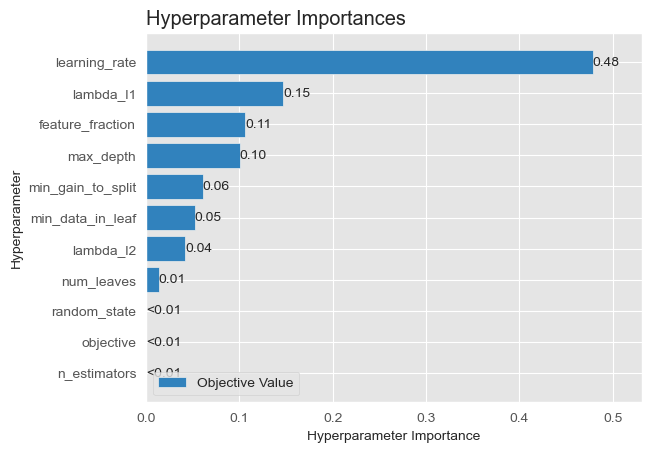

In [35]:
plot_param_importances(study)

In [36]:
best_params_ver1 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver1)

model = Pipeline([('columnTransformer', preprocessor),
                 ('lgb', lgb_optuna)])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'LGBoost_Optuna'))
round(metrics.set_index('model'), 3)

[LightGBM] [Warning] lambda_l1 is set=0.0010299670758205145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010299670758205145
[LightGBM] [Warning] feature_fraction is set=0.7127975277113354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7127975277113354
[LightGBM] [Warning] lambda_l2 is set=0.0052211090324371075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052211090324371075
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] min_data_in_leaf is set=267, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=267
[LightGBM] [Warning] lambda_l1 is set=0.0010299670758205145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010299670758205145
[LightGBM] [Warning] feature_fraction is set=0.7127975277113354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7127975277113354
[LightGBM] [Warning] lambda_l2

MAE           MSE         RMSE  RMSLE  \
model                                                                       
LinearRegression_baseline   2416599.150  1.127996e+13  3358564.859  0.285   
LGBMRegressor_baseline      2051111.232  9.366521e+12  3060477.221  0.247   
CatBoostRegressor_baseline  2054289.246  9.360950e+12  3059566.884  0.247   
LGBoost_Optuna              1974515.360  8.884606e+12  2980705.686  0.241   

                            R2 adjusted  MPE_%  MAPE_%  WAPE_%  
model                                                           
LinearRegression_baseline         0.532 -7.465  23.658  22.601  
LGBMRegressor_baseline            0.611 -1.811  18.702  19.183  
CatBoostRegressor_baseline        0.612 -1.852  18.748  19.212  
LGBoost_Optuna                    0.631 -1.646  17.990  18.466

In [37]:
check_overfitting(model,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

[LightGBM] [Warning] lambda_l1 is set=0.0010299670758205145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010299670758205145
[LightGBM] [Warning] feature_fraction is set=0.7127975277113354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7127975277113354
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l2 is set=0.0052211090324371075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052211090324371075
[LightGBM] [Warning] min_data_in_leaf is set=267, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=267
[LightGBM] [Warning] lambda_l1 is set=0.0010299670758205145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010299670758205145
[LightGBM] [Warning] feature_fraction is set=0.7127975277113354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7127975277113354
[LightGBM] [Warning] min_gain_

In [38]:
study.optimize(func, n_trials=25, show_progress_bar=True)

  0%|          | 0/25 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.011657733848163826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011657733848163826
[LightGBM] [Warning] feature_fraction is set=0.7004048062538778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7004048062538778
[LightGBM] [Warning] lambda_l2 is set=0.06843311113624036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06843311113624036
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] min_data_in_leaf is set=456, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=456
[LightGBM] [Warning] lambda_l1 is set=0.011657733848163826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011657733848163826
[LightGBM] [Warning] feature_fraction is set=0.7004048062538778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7004048062538778
[LightGBM] [Warning] lambda_l2 is set=

In [39]:
best_params_ver2 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver2)

model = Pipeline([('columnTransformer', preprocessor),
                  ('lgb', lgb_optuna)])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'LGBoost_Optuna_ver2'))
round(metrics.set_index('model'), 3)

[LightGBM] [Warning] lambda_l1 is set=0.0036773058732248102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036773058732248102
[LightGBM] [Warning] feature_fraction is set=0.9450877865820494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450877865820494
[LightGBM] [Warning] lambda_l2 is set=1.2536357070461335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2536357070461335
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=663, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=663
[LightGBM] [Warning] lambda_l1 is set=0.0036773058732248102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036773058732248102
[LightGBM] [Warning] feature_fraction is set=0.9450877865820494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450877865820494
[LightGBM] [Warning] lambda_l2 is se

MAE           MSE         RMSE  RMSLE  \
model                                                                       
LinearRegression_baseline   2416599.150  1.127996e+13  3358564.859  0.285   
LGBMRegressor_baseline      2051111.232  9.366521e+12  3060477.221  0.247   
CatBoostRegressor_baseline  2054289.246  9.360950e+12  3059566.884  0.247   
LGBoost_Optuna              1974515.360  8.884606e+12  2980705.686  0.241   
LGBoost_Optuna_ver2         1920047.558  8.548842e+12  2923840.246  0.237   

                            R2 adjusted  MPE_%  MAPE_%  WAPE_%  
model                                                           
LinearRegression_baseline         0.532 -7.465  23.658  22.601  
LGBMRegressor_baseline            0.611 -1.811  18.702  19.183  
CatBoostRegressor_baseline        0.612 -1.852  18.748  19.212  
LGBoost_Optuna                    0.631 -1.646  17.990  18.466  
LGBoost_Optuna_ver2               0.645 -1.695  17.528  17.957

In [40]:
check_overfitting(model,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

[LightGBM] [Warning] lambda_l1 is set=0.0036773058732248102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036773058732248102
[LightGBM] [Warning] feature_fraction is set=0.9450877865820494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450877865820494
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l2 is set=1.2536357070461335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2536357070461335
[LightGBM] [Warning] min_data_in_leaf is set=663, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=663
[LightGBM] [Warning] lambda_l1 is set=0.0036773058732248102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036773058732248102
[LightGBM] [Warning] feature_fraction is set=0.9450877865820494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450877865820494
[LightGBM] [Warning] min_gain_to_spl

## CatBoostRegressor

In [41]:
from catboost import Pool


# целевая функция
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True), #0.07
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        #"l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),        
        #"bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        #'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),

        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        'loss_function': trial.suggest_categorical("loss_function", ['MAE']),
        "eval_metric": trial.suggest_categorical("eval_metric", ['MAE']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "allow_writing_files": trial.suggest_categorical("allow_writing_files", [False])
    }

    #if params["bootstrap_type"] == "Bayesian":
    #    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    #elif params["bootstrap_type"] == "Bernoulli":
    #    params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [42]:
study_cat = optuna.create_study(direction="minimize", study_name="Cat_02")


def func_cat(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND,
                         cat_feat=CATEGORICAL_FEATURES)


study_cat.optimize(func_cat, n_trials=3, show_progress_bar=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
best_params = study_cat.best_params
# best_params['eval_set'] = eval_set
best_params

{'n_estimators': 300,
 'learning_rate': 0.14576781861855528,
 'max_depth': 12,
 'use_best_model': True,
 'loss_function': 'MAE',
 'eval_metric': 'MAE',
 'random_state': 10,
 'allow_writing_files': False}

In [50]:
eval_set = [(X_val, y_val)]
# best_params['eval_set'] = eval_set

# cat_optuna = CatBoostRegressor(**best_params)
cat_optuna = CatBoostRegressor(n_estimators=300,
                               learning_rate=0.14576781861855528,
                               max_depth=12,
                               loss_function='MAE',
                               eval_metric='MAE',
                               random_state=10,
                               allow_writing_files=False
                               )

model = Pipeline([('columnTransformer', preprocessor),
                 ('cat', cat_optuna)])
model.fit(X_train, y_train)

0:	learn: 3273949.5716109	total: 91.8ms	remaining: 27.4s
1:	learn: 3035482.6618776	total: 151ms	remaining: 22.5s
2:	learn: 2851600.1237129	total: 185ms	remaining: 18.3s
3:	learn: 2705697.4531132	total: 214ms	remaining: 15.8s
4:	learn: 2592610.0468809	total: 237ms	remaining: 14s
5:	learn: 2501402.8713157	total: 261ms	remaining: 12.8s
6:	learn: 2432205.1941662	total: 286ms	remaining: 12s
7:	learn: 2374828.4300404	total: 312ms	remaining: 11.4s
8:	learn: 2333065.0884550	total: 342ms	remaining: 11.1s
9:	learn: 2294756.1710958	total: 368ms	remaining: 10.7s
10:	learn: 2266108.6764892	total: 394ms	remaining: 10.4s
11:	learn: 2241135.7655395	total: 418ms	remaining: 10s
12:	learn: 2221256.1649980	total: 442ms	remaining: 9.75s
13:	learn: 2204344.8318530	total: 466ms	remaining: 9.53s
14:	learn: 2190293.5830986	total: 491ms	remaining: 9.32s
15:	learn: 2177893.6568470	total: 516ms	remaining: 9.15s
16:	learn: 2166290.6397825	total: 540ms	remaining: 9s
17:	learn: 2156645.4701643	total: 565ms	remaining

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['level', 'levels', 'rooms',
                                                   'area', 'kitchen_area']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['building_type',
                                                   'object_type'])])),
                ('cat',
                 <catboost.core.CatBoostRegressor object at 0x2b5111810>)])

In [51]:
y_pred = model.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'CatBoostRegressor_Optuna'))
round(metrics.set_index('model'), 3)

MAE           MSE         RMSE  RMSLE  \
model                                                                       
LinearRegression_baseline   2416599.150  1.127996e+13  3358564.859  0.285   
LGBMRegressor_baseline      2051111.232  9.366521e+12  3060477.221  0.247   
CatBoostRegressor_baseline  2054289.246  9.360950e+12  3059566.884  0.247   
LGBoost_Optuna              1974515.360  8.884606e+12  2980705.686  0.241   
LGBoost_Optuna_ver2         1920047.558  8.548842e+12  2923840.246  0.237   
CatBoostRegressor_Optuna    1853007.144  8.096096e+12  2845364.014  0.231   

                            R2 adjusted  MPE_%  MAPE_%  WAPE_%  
model                                                           
LinearRegression_baseline         0.532 -7.465  23.658  22.601  
LGBMRegressor_baseline            0.611 -1.811  18.702  19.183  
CatBoostRegressor_baseline        0.612 -1.852  18.748  19.212  
LGBoost_Optuna                    0.631 -1.646  17.990  18.466  
LGBoost_Optuna_ver2               0.645 -1.695  17.528  17.957  
CatBoostRegressor_Optuna          0.664 -1.576  16.952  17.330

In [54]:
check_overfitting(model,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 1762292.502
mean_absolute_error test: 1853007.144
delta = 5.1 %


## Feature importance

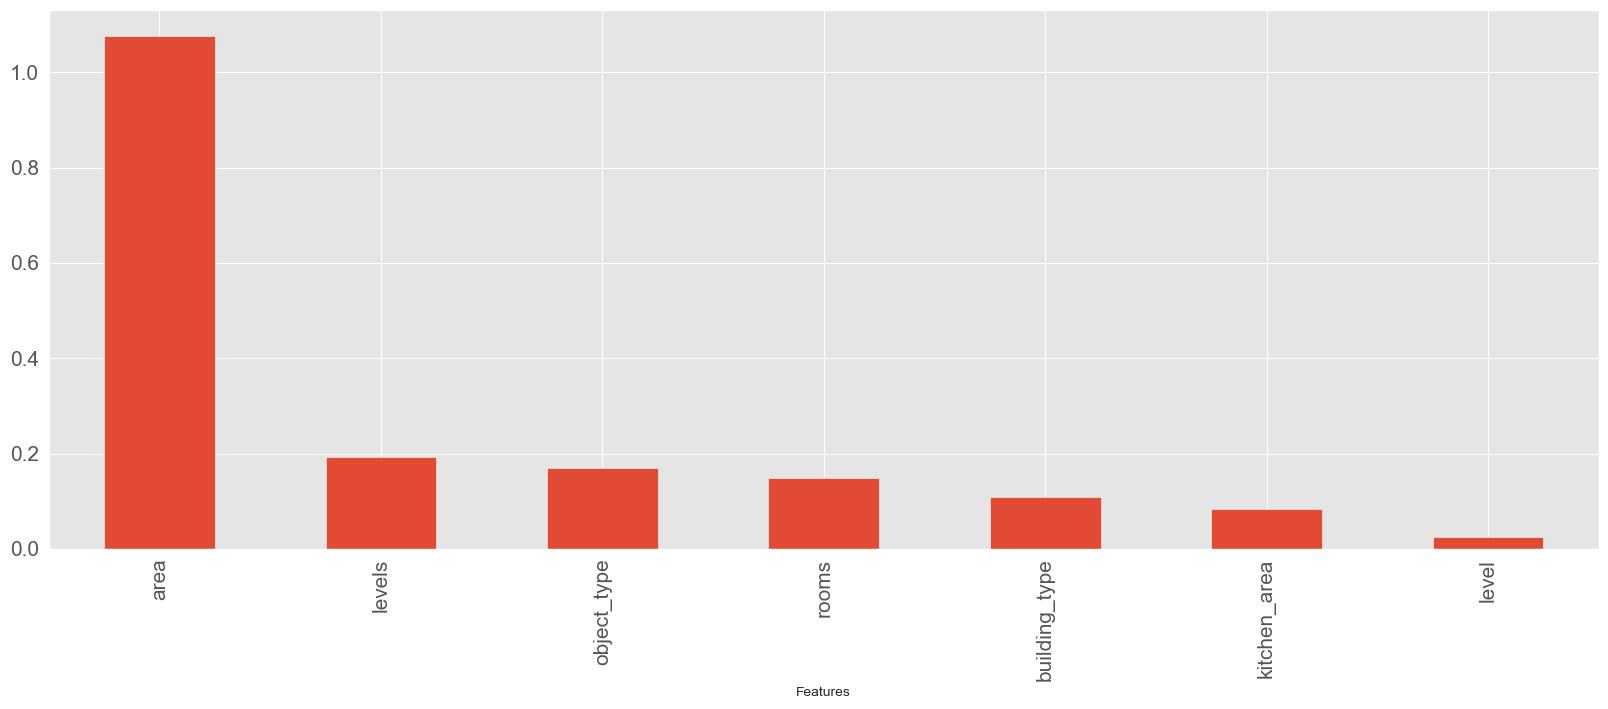

In [56]:
from sklearn.inspection import permutation_importance


r = permutation_importance(model, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()